In [1]:

## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [2]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [3]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
# module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
# sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [4]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
if run_google_colab:
    obs_file = './XRO_indices_oras5.nc'
else:
    # obs_file = '../data/XRO_indices_oras5.nc'
    obs_file = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/XRO_indices_oras5.nc'

# obs_ds = xr.open_dataset(obs_file).sel(time=slice('1979-01', '2024-12'))
obs_ds = xr.open_dataset(obs_file).sel(time=slice('1998-01', '2024-12'))

obs_RO_ds = obs_ds[['Nino34', 'WWV']]
print(obs_RO_ds)

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 324)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-12-01
    month    (time) int32 1kB ...
Data variables:
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...


In [5]:
obs_ds

<xarray.Dataset> Size: 17kB
Dimensions:  (time: 324)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-12-01
    month    (time) int32 1kB ...
Data variables:
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...
    NPMM     (time) float32 1kB ...
    SPMM     (time) float32 1kB ...
    IOB      (time) float32 1kB ...
    IOD      (time) float32 1kB ...
    SIOD     (time) float32 1kB ...
    TNA      (time) float32 1kB ...
    ATL3     (time) float32 1kB ...
    SASD     (time) float32 1kB ...

In [6]:
import xarray as xr
import numpy as np
import glob
import os

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
DATA_DIR = "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/preprocessed"
OUT_FILE = os.path.join(DATA_DIR, "XRO_input_LE_merged.nc")

# ------------------------------------------------------------
# List all preprocessed files
# ------------------------------------------------------------
file_list = sorted(glob.glob(os.path.join(DATA_DIR, "XRO_input_LE_*_preproc.nc")))
print(f"Found {len(file_list)} files")

# ------------------------------------------------------------
# Read files and collect into dictionary
# ------------------------------------------------------------
data_dict = {}

for f in file_list:
    name = os.path.basename(f).replace("XRO_input_LE_", "").replace("_preproc.nc", "")
    ds = xr.open_dataset(f)
    
    # Automatically detect variable name
    varname = [v for v in ds.data_vars][0]
    data_dict[name] = ds[varname]
    print(f"Loaded: {name} ({varname})")

# ------------------------------------------------------------
# Handle dipole indices (e.g., IOD1 - IOD2)
# ------------------------------------------------------------
def subtract_if_exists(dict_in, var1, var2, newname):
    """If both var1 and var2 exist, compute var1 - var2."""
    if var1 in dict_in and var2 in dict_in:
        dict_in[newname] = dict_in[var1] - dict_in[var2]
        del dict_in[var1]
        del dict_in[var2]
        print(f"Created dipole index: {newname} = {var1} - {var2}")
    return dict_in

data_dict = subtract_if_exists(data_dict, "IOD1", "IOD2", "IOD")
data_dict = subtract_if_exists(data_dict, "SIOD1", "SIOD2", "SIOD")
data_dict = subtract_if_exists(data_dict, "SASD1", "SASD2", "SASD")

# ------------------------------------------------------------
# Merge all into one dataset
# ------------------------------------------------------------
# Align time dimension (some datasets may differ slightly)
first_key = list(data_dict.keys())[0]
time_coord = data_dict[first_key].time

for k in data_dict:
    data_dict[k] = data_dict[k].interp(time=time_coord)

merged_ds = xr.Dataset(data_dict)

print("\n✅ Final merged dataset:")
print(merged_ds)

# ------------------------------------------------------------
# Save merged dataset
# ------------------------------------------------------------
encoding = {v: {"zlib": True, "complevel": 4} for v in merged_ds.data_vars}
merged_ds.to_netcdf(OUT_FILE, encoding=encoding)

merged_ds
merged_ds=merged_ds.rename({"ENSO": "Nino34"})

print(f"\n🎉 Saved merged dataset to {OUT_FILE}")


Found 13 files
Loaded: ATL3 (ATL3)
Loaded: ENSO (ENSO)
Loaded: IOB (IOB)
Loaded: IOD1 (IOD1)
Loaded: IOD2 (IOD2)
Loaded: NPMM (NPMM)
Loaded: SASD1 (SASD1)
Loaded: SASD2 (SASD2)
Loaded: SIOD1 (SIOD1)
Loaded: SIOD2 (SIOD2)
Loaded: SPMM (SPMM)
Loaded: TNA (TNA)
Loaded: WWV (WWV)
Created dipole index: IOD = IOD1 - IOD2
Created dipole index: SIOD = SIOD1 - SIOD2
Created dipole index: SASD = SASD1 - SASD2

✅ Final merged dataset:
<xarray.Dataset> Size: 202kB
Dimensions:  (ens_LE: 1, time: 2100)
Coordinates:
  * ens_LE   (ens_LE) int64 8B 0
    month    (time) float64 17kB 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * time     (time) datetime64[ns] 17kB 1850-01-17 1850-02-14 ... 2024-12-17
Data variables:
    ATL3     (ens_LE, time) float64 17kB -0.524 -0.3991 ... -0.1777 -0.05742
    ENSO     (ens_LE, time) float64 17kB -0.3372 0.03305 ... -0.2521 -0.0008753
    IOB      (ens_LE, time) float64 17kB -0.2415 -0.2101 ... -0.03089 0.1092
    NPMM     (ens_LE, time) float64 17kB -0.3988 -0.7

In [7]:
merged_ds = merged_ds.isel(ens_LE=0)

In [8]:
merged_ds

<xarray.Dataset> Size: 202kB
Dimensions:  (time: 2100)
Coordinates:
    ens_LE   int64 8B 0
    month    (time) float64 17kB 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * time     (time) datetime64[ns] 17kB 1850-01-17 1850-02-14 ... 2024-12-17
Data variables:
    ATL3     (time) float64 17kB -0.524 -0.3991 -0.08045 ... -0.1777 -0.05742
    Nino34   (time) float64 17kB -0.3372 0.03305 0.4784 ... -0.2521 -0.0008753
    IOB      (time) float64 17kB -0.2415 -0.2101 -0.1637 ... -0.03089 0.1092
    NPMM     (time) float64 17kB -0.3988 -0.791 -0.9657 ... 0.158 0.08897 0.464
    SPMM     (time) float64 17kB -0.693 -0.5451 -0.3803 ... -0.4113 -0.3223
    TNA      (time) float64 17kB -0.02722 -0.04757 0.1897 ... -0.1808 0.1256
    WWV      (time) float64 17kB 521.4 564.6 442.5 ... 813.8 841.5 1.209e+03
    IOD      (time) float64 17kB -0.3432 0.09039 -0.1434 ... -0.9844 -0.5499
    SIOD     (time) float64 17kB -0.4796 -0.3704 -0.3442 ... -0.2877 0.1522
    SASD     (time) float64 17kB 0.5599 0.5039 0.01307 ... 0.5605 1.042 0.3896

In [9]:
import pandas as pd


# --- Convert time to datetime64 if not already ---
if (
    "cftime" in str(type(merged_ds.time.values[0]))
    or "CFTimeIndex" in str(type(merged_ds.indexes.get("time", None)))
):
    merged_ds["time"] = merged_ds.indexes["time"].to_datetimeindex()
elif not pd.api.types.is_datetime64_any_dtype(merged_ds.time):
    merged_ds = xr.decode_cf(merged_ds)

# --- Create target obs-style time axis (1979-01-01 → 2024-12-01) ---
obs_time = pd.date_range("1850-01-01", "2024-12-01", freq="MS")

# --- Ensure same length before assigning ---
n_model = merged_ds.sizes["time"]
n_obs = len(obs_time)
n_min = min(n_model, n_obs)

merged_ds = merged_ds.isel(time=slice(0, n_min))
obs_time = obs_time[:n_min]

# --- Replace with new monthly timestamps ---
merged_ds = merged_ds.assign_coords(time=("time", obs_time))



In [10]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('2000-01', '2024-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

In [46]:
XRO_ac0 = XRO(ncycle=12, ac_order=0, is_forward=True)
XRO_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)
XRO_ac2 = XRO(ncycle=12, ac_order=2, is_forward=True)

model_XRO_ds = merged_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
model_NRO_ds = merged_ds[['Nino34', 'WWV']]

model_XRO_ds_3rm=model_XRO_ds.rolling(time=3, center=True, min_periods=1).mean(dim='time')
model_NRO_ds_3rm=model_NRO_ds.rolling(time=3, center=True, min_periods=1).mean(dim='time')

In [13]:
slice_train = slice('1850-01', '1999-12')
slice_verif = slice('2000-01', '2024-12')

fit_XRO_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_NRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_LRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample = calc_forecast_skill(LRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_LRO_outofsample = calc_forecast_skill(LRO_outofsample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 1800), total X shape: (12, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 

In [38]:
acc_XRO_outofsample_1m = calc_forecast_skill(XRO_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))

In [49]:
slice_train = slice('1850-01', '1999-12')
slice_verif = slice('2000-01', '2024-12')

fit_XRO_train_3rm = XRO_ac1.fit_matrix(model_XRO_ds_3rm.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst_3rm = XRO_ac1.reforecast(fit_ds=fit_XRO_train_3rm, init_ds=model_XRO_ds_3rm.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample_3rm = calc_forecast_skill(XRO_outofsample_fcst_3rm, model_XRO_ds_3rm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))
acc_XRO_outofsample_3rm_o1m = calc_forecast_skill(XRO_outofsample_fcst_3rm, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_XRO_outofsample_3rm = calc_forecast_skill(XRO_outofsample_fcst_3rm, model_XRO_ds_3rm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_NRO_train_3rm = XRO_ac1.fit_matrix(model_NRO_ds_3rm.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst_3rm = XRO_ac1.reforecast(fit_ds=fit_NRO_train_3rm, init_ds=model_NRO_ds_3rm.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample_3rm = calc_forecast_skill(NRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_NRO_outofsample_3rm = calc_forecast_skill(NRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train_3rm = XRO_ac1.fit_matrix(model_NRO_ds_3rm.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst_3rm = XRO_ac1.reforecast(fit_ds=fit_LRO_train_3rm, init_ds=model_NRO_ds_3rm.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample_3rm = calc_forecast_skill(LRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_LRO_outofsample_3rm = calc_forecast_skill(LRO_outofsample_fcst_3rm, model_NRO_ds_3rm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=False, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 1800), total X shape: (12, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 

In [14]:
fit_XRO_L_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=[], maskNH=[], maskb=[])

XRO_L_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_L_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_L_outofsample = calc_forecast_skill(XRO_L_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_L_outofsample = calc_forecast_skill(XRO_L_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_Q_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'], maskb=[])

XRO_Q_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_Q_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_Q_outofsample = calc_forecast_skill(XRO_Q_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_Q_outofsample = calc_forecast_skill(XRO_Q_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_C_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['TH'], maskNH=[], maskb=[])

XRO_C_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_C_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_C_outofsample = calc_forecast_skill(XRO_C_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_C_outofsample = calc_forecast_skill(XRO_C_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_QC_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=[])

XRO_QC_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_QC_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_QC_outofsample = calc_forecast_skill(XRO_QC_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_QC_outofsample = calc_forecast_skill(XRO_QC_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_I_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_I_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_I_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_I_outofsample = calc_forecast_skill(XRO_I_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_I_outofsample = calc_forecast_skill(XRO_I_outofsample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape

In [32]:
slice_train = slice('1850-01', '1999-12')
slice_verif = slice('2000-01', '2024-12')

fit_XRO_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample2 = calc_forecast_skill(XRO_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_outofsample2 = calc_forecast_skill(XRO_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_NRO_train2 = XRO_ac2.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_NRO_train2, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample2 = calc_forecast_skill(NRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_NRO_outofsample2 = calc_forecast_skill(NRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

# fit_LRO_NPP = XRO_ac2.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train2 = XRO_ac2.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_LRO_train2, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample2 = calc_forecast_skill(LRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_LRO_outofsample2 = calc_forecast_skill(LRO_outofsample_fcst2, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 1800), total X shape: (12, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 

In [35]:
fit_XRO_L_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=[], maskNH=[], maskb=[])

XRO_L_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_L_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_L_outofsample2 = calc_forecast_skill(XRO_L_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_L_outofsample2 = calc_forecast_skill(XRO_L_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_Q_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'], maskb=[])

XRO_Q_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_Q_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_Q_outofsample2 = calc_forecast_skill(XRO_Q_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_Q_outofsample2 = calc_forecast_skill(XRO_Q_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_C_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['TH'], maskNH=[], maskb=[])

XRO_C_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_C_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_C_outofsample2 = calc_forecast_skill(XRO_C_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_C_outofsample2 = calc_forecast_skill(XRO_C_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_QC_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=[])

XRO_QC_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_QC_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_QC_outofsample2 = calc_forecast_skill(XRO_QC_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_QC_outofsample2 = calc_forecast_skill(XRO_QC_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_I_train2 = XRO_ac2.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_I_outofsample_fcst2 = XRO_ac2.reforecast(fit_ds=fit_XRO_I_train2, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_I_outofsample2 = calc_forecast_skill(XRO_I_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_I_outofsample2 = calc_forecast_skill(XRO_I_outofsample_fcst2, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape

In [33]:
slice_train = slice('1850-01', '1999-12')
slice_verif = slice('2000-01', '2024-12')

fit_XRO_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_outofsample0 = calc_forecast_skill(XRO_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_outofsample0 = calc_forecast_skill(XRO_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_NRO_train0 = XRO_ac0.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_NRO_train0, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_outofsample0 = calc_forecast_skill(NRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_NRO_outofsample0 = calc_forecast_skill(NRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

# fit_LRO_NPP = XRO_ac0.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train0 = XRO_ac0.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_LRO_train0, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_outofsample0 = calc_forecast_skill(LRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_LRO_outofsample0 = calc_forecast_skill(LRO_outofsample_fcst0, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 1800), total X shape: (12, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 

In [36]:
fit_XRO_L_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=[], maskNH=[], maskb=[])

XRO_L_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_L_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_L_outofsample0 = calc_forecast_skill(XRO_L_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_L_outofsample0 = calc_forecast_skill(XRO_L_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_Q_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'], maskb=[])

XRO_Q_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_Q_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_Q_outofsample0 = calc_forecast_skill(XRO_Q_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_Q_outofsample0 = calc_forecast_skill(XRO_Q_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_C_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['TH'], maskNH=[], maskb=[])

XRO_C_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_C_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_C_outofsample0 = calc_forecast_skill(XRO_C_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_C_outofsample0 = calc_forecast_skill(XRO_C_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_QC_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=[])

XRO_QC_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_QC_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_QC_outofsample0 = calc_forecast_skill(XRO_QC_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_QC_outofsample0 = calc_forecast_skill(XRO_QC_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_XRO_I_train0 = XRO_ac0.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_I_outofsample_fcst0 = XRO_ac0.reforecast(fit_ds=fit_XRO_I_train0, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_I_outofsample0 = calc_forecast_skill(XRO_I_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_I_outofsample0 = calc_forecast_skill(XRO_I_outofsample_fcst0, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape

In [53]:
slice_train = slice('1979-01', '2022-12')
slice_verif = slice('1979-01', '2022-12')

fit_XRO_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_insample = calc_forecast_skill(XRO_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)

rmse_XRO_insample = calc_forecast_skill(XRO_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

fit_NRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_insample = calc_forecast_skill(NRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_NRO_insample = calc_forecast_skill(NRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_LRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_insample = calc_forecast_skill(LRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice_verif)
rmse_LRO_insample = calc_forecast_skill(LRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice_verif)

Y shape: (1, 528)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 528), total X shape: (12, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 528), total X shape: (11, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 528), total X shape: (10, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 528), total X shape: (10, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 528), total X shape: (10, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 528), total X shape: (11, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 528), total X shape: (10, 528)
Y shape: (1, 528)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inacti

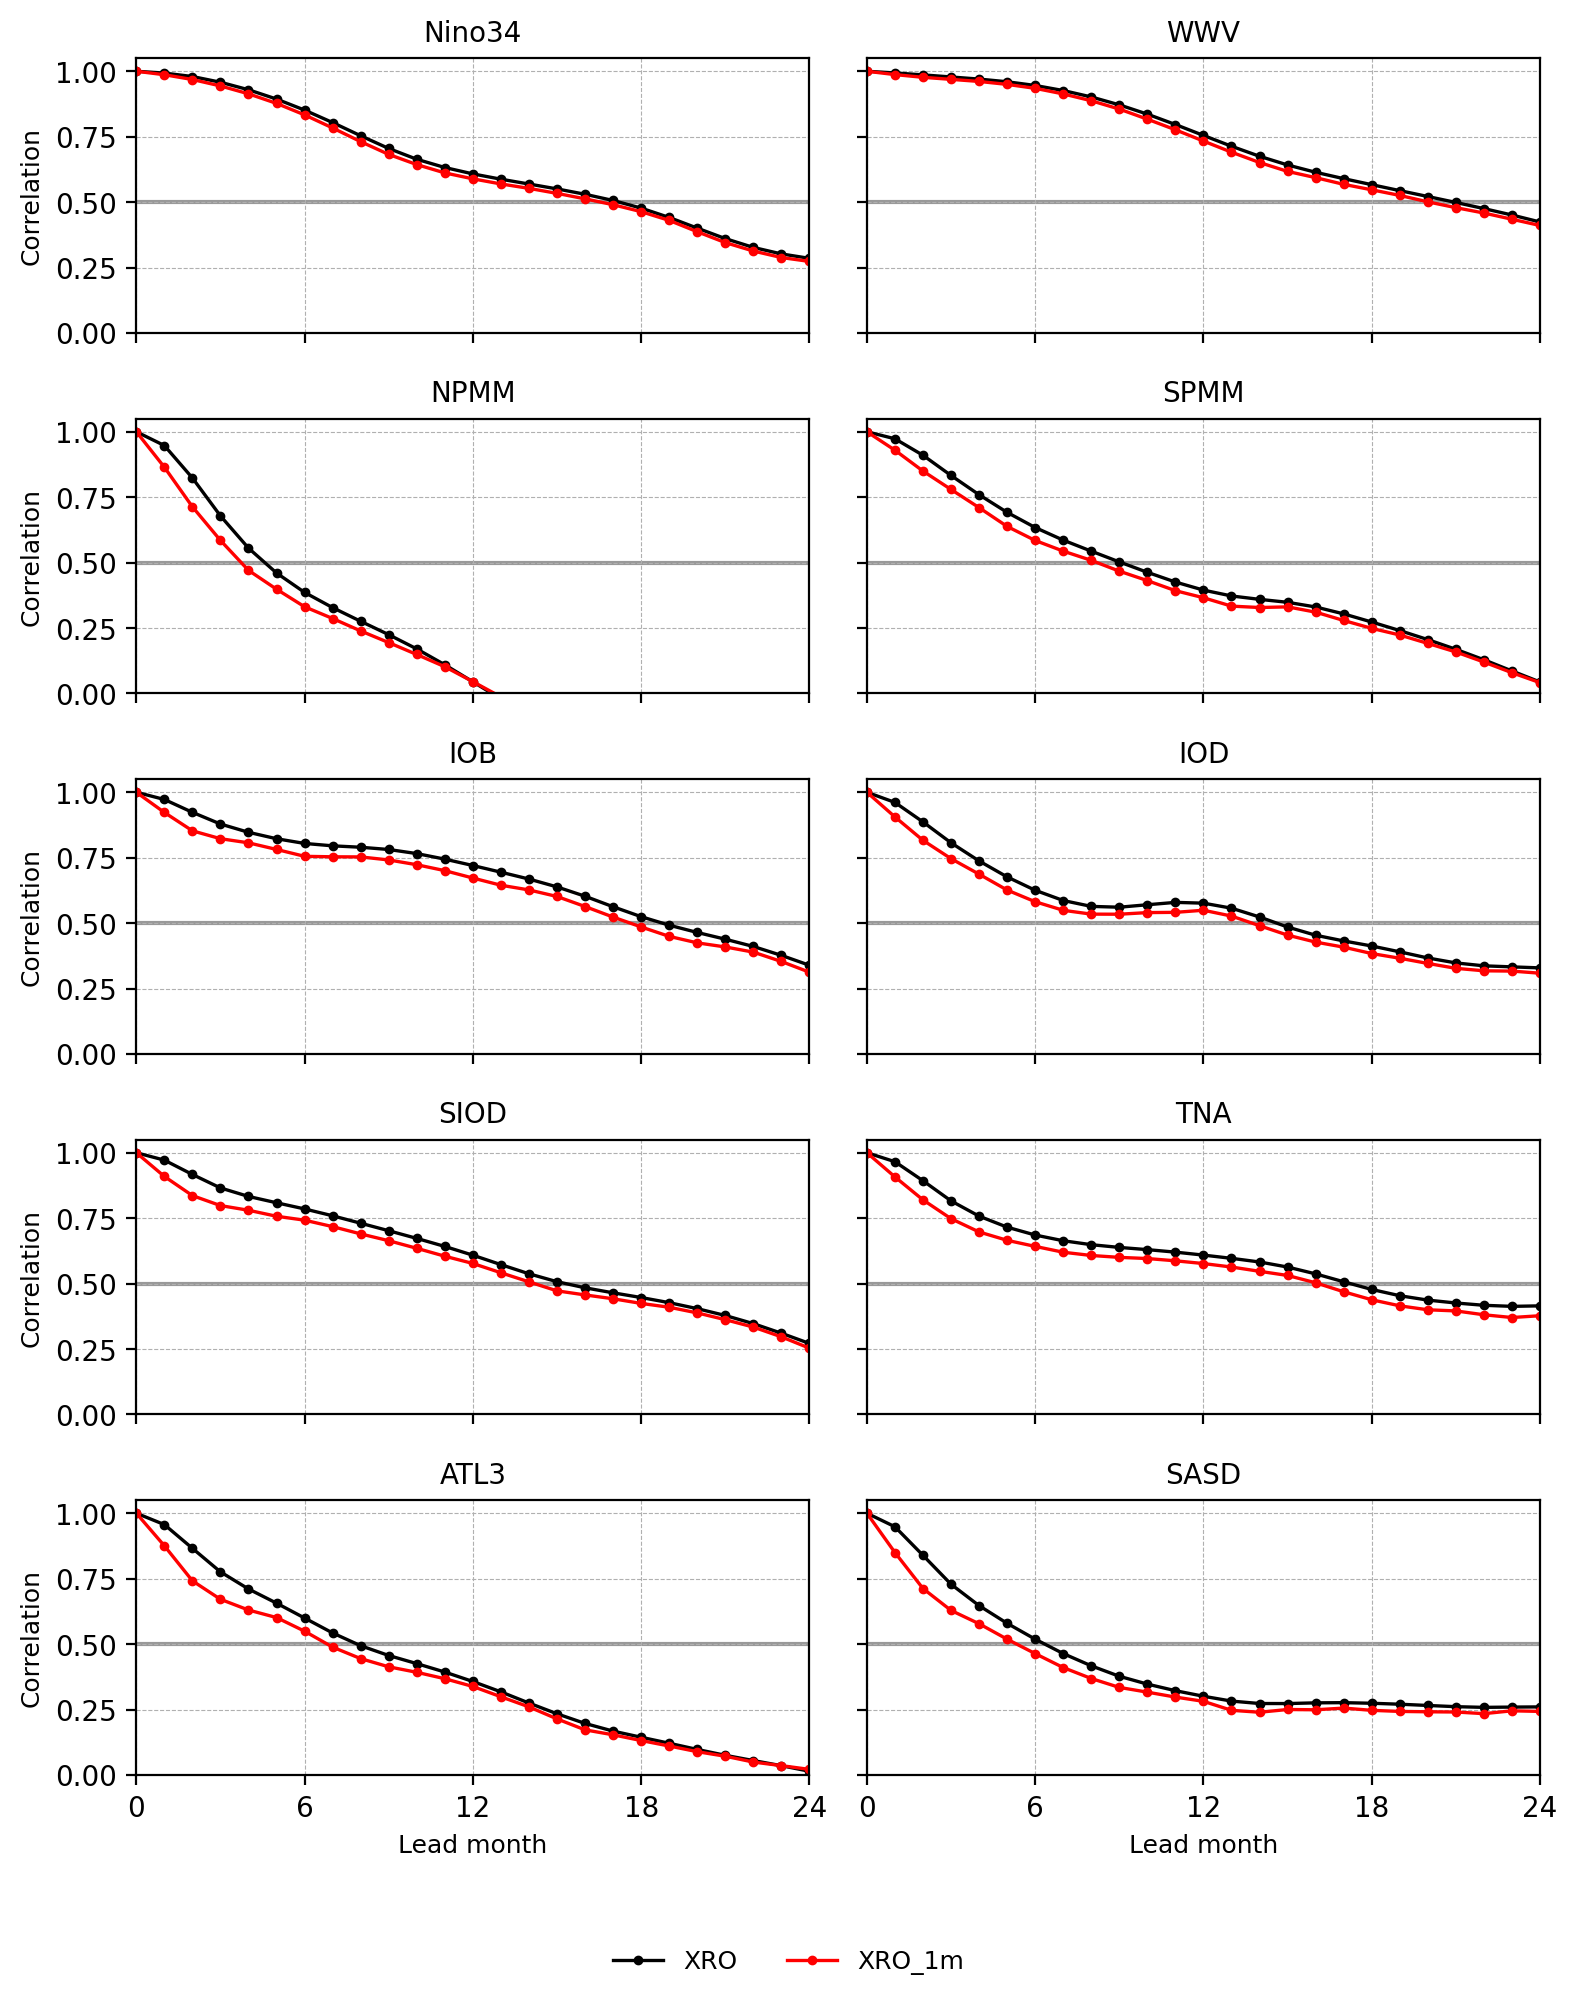

In [40]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_outofsample,
    "XRO_1m": acc_XRO_outofsample_1m,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "XRO_1m": "red",
}
labels = {
    "XRO": "XRO",
    "XRO_1m": "XRO_1m",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


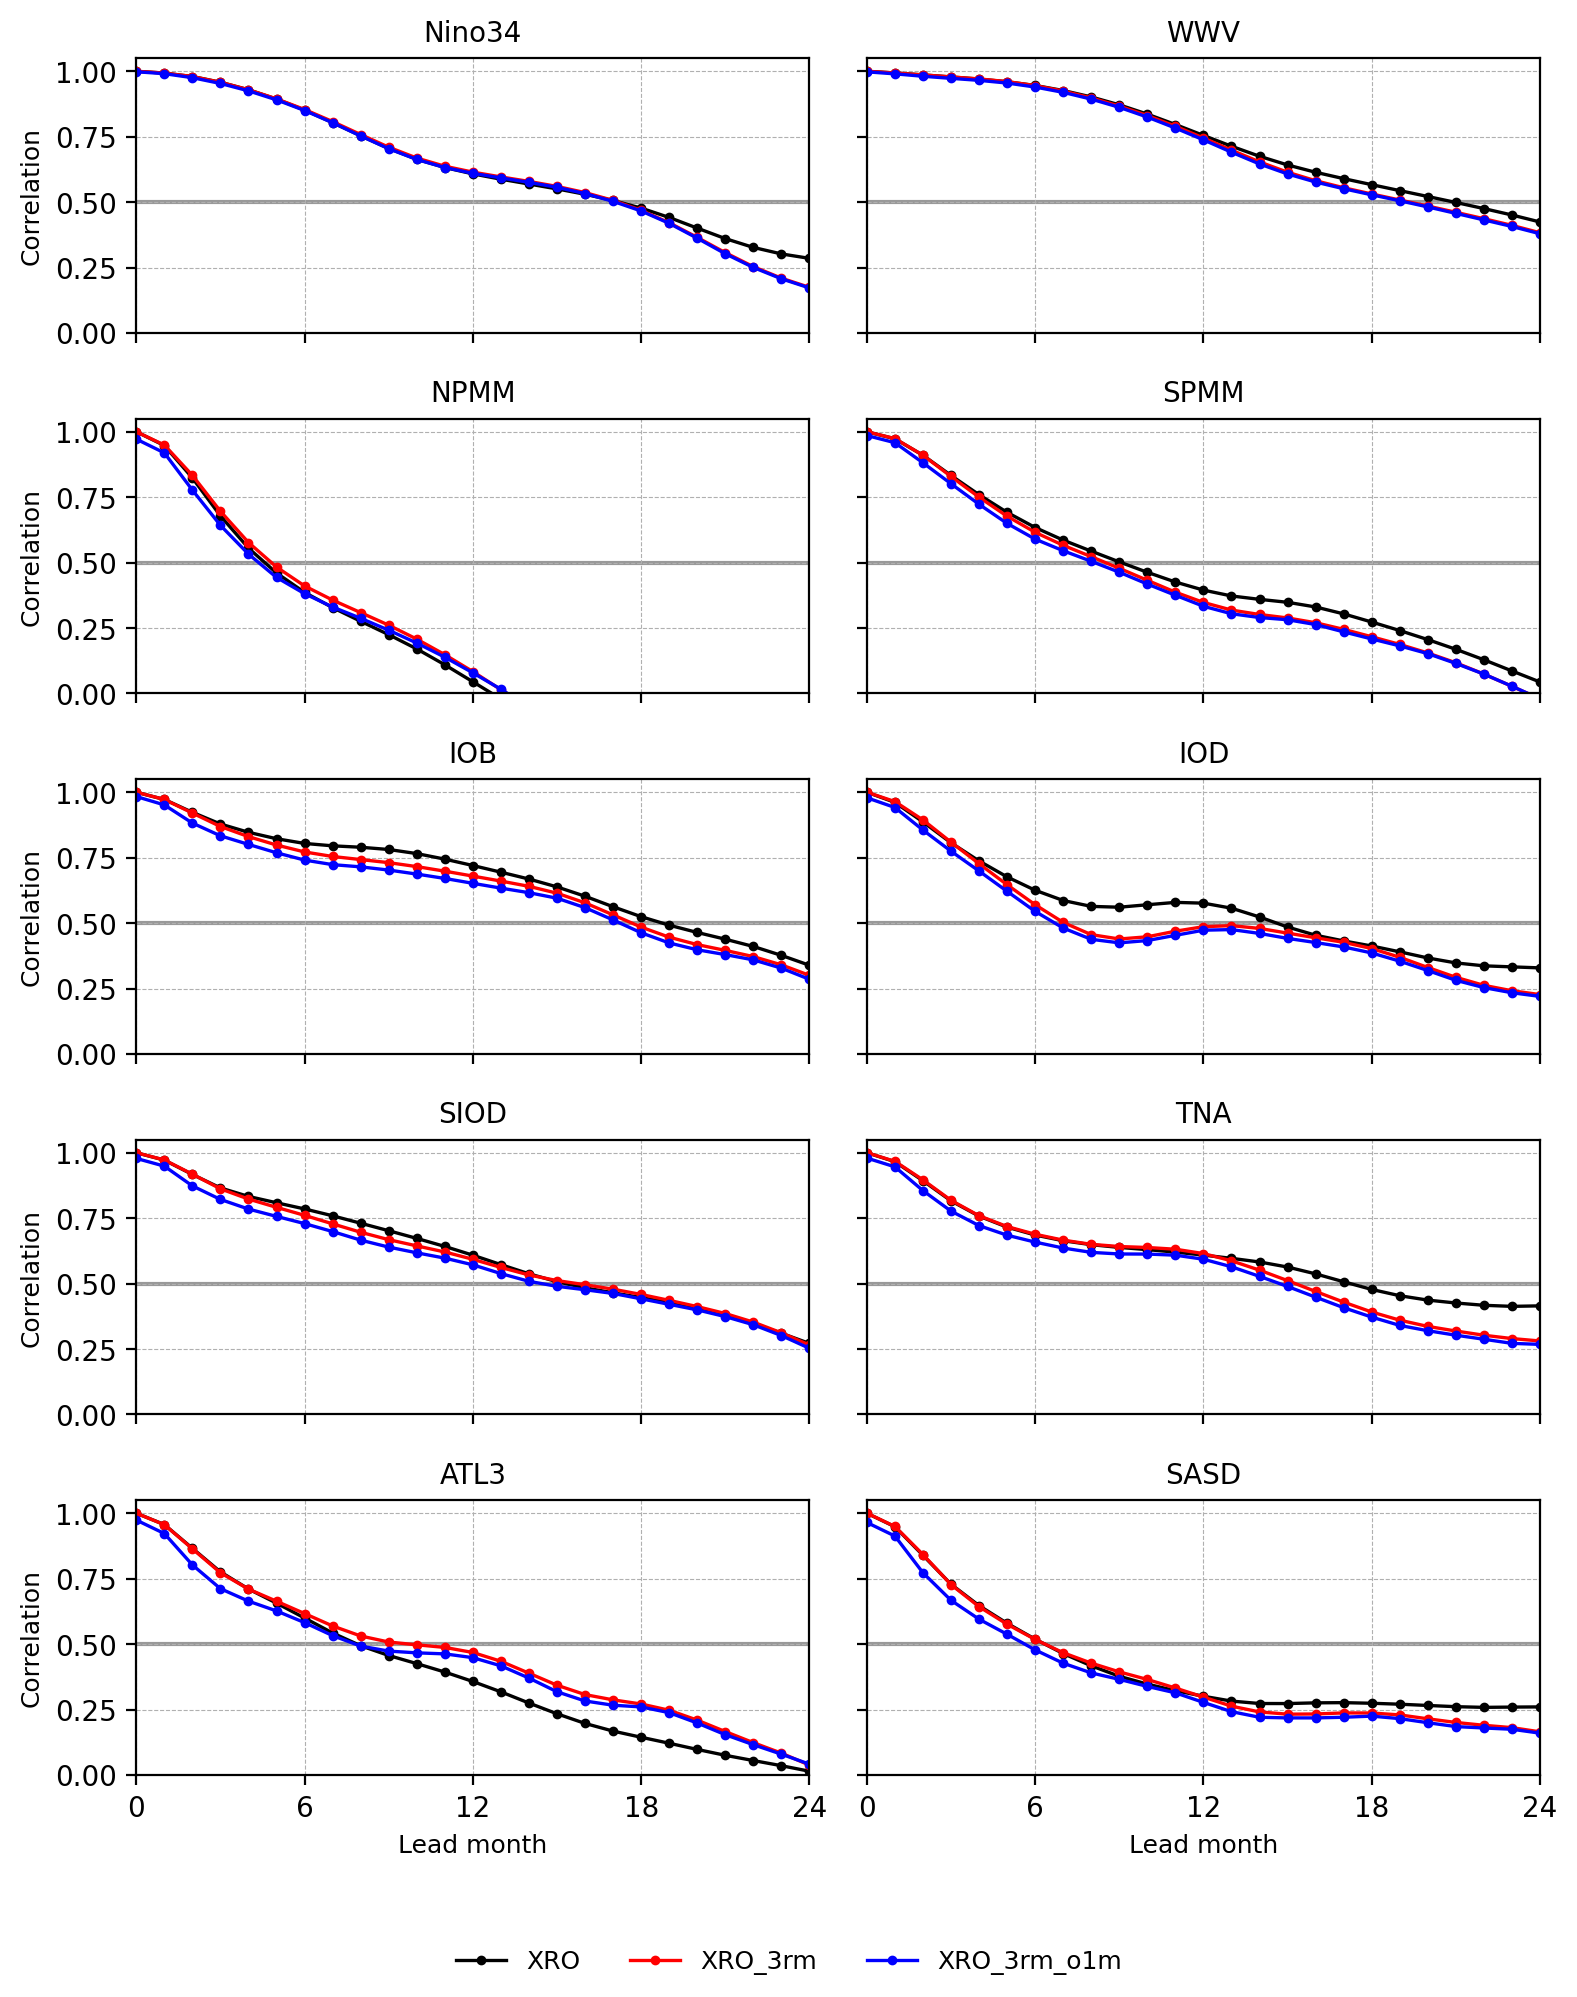

In [52]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_outofsample,
    "XRO_3rm": acc_XRO_outofsample_3rm,
    "XRO_3rm_o1m": acc_XRO_outofsample_3rm_o1m,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "XRO_3rm": "red",
    "XRO_3rm_o1m": "blue",
}
labels = {
    "XRO": "XRO",
    "XRO_3rm": "XRO_3rm",
    "XRO_3rm_o1m": "XRO_3rm_o1m",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


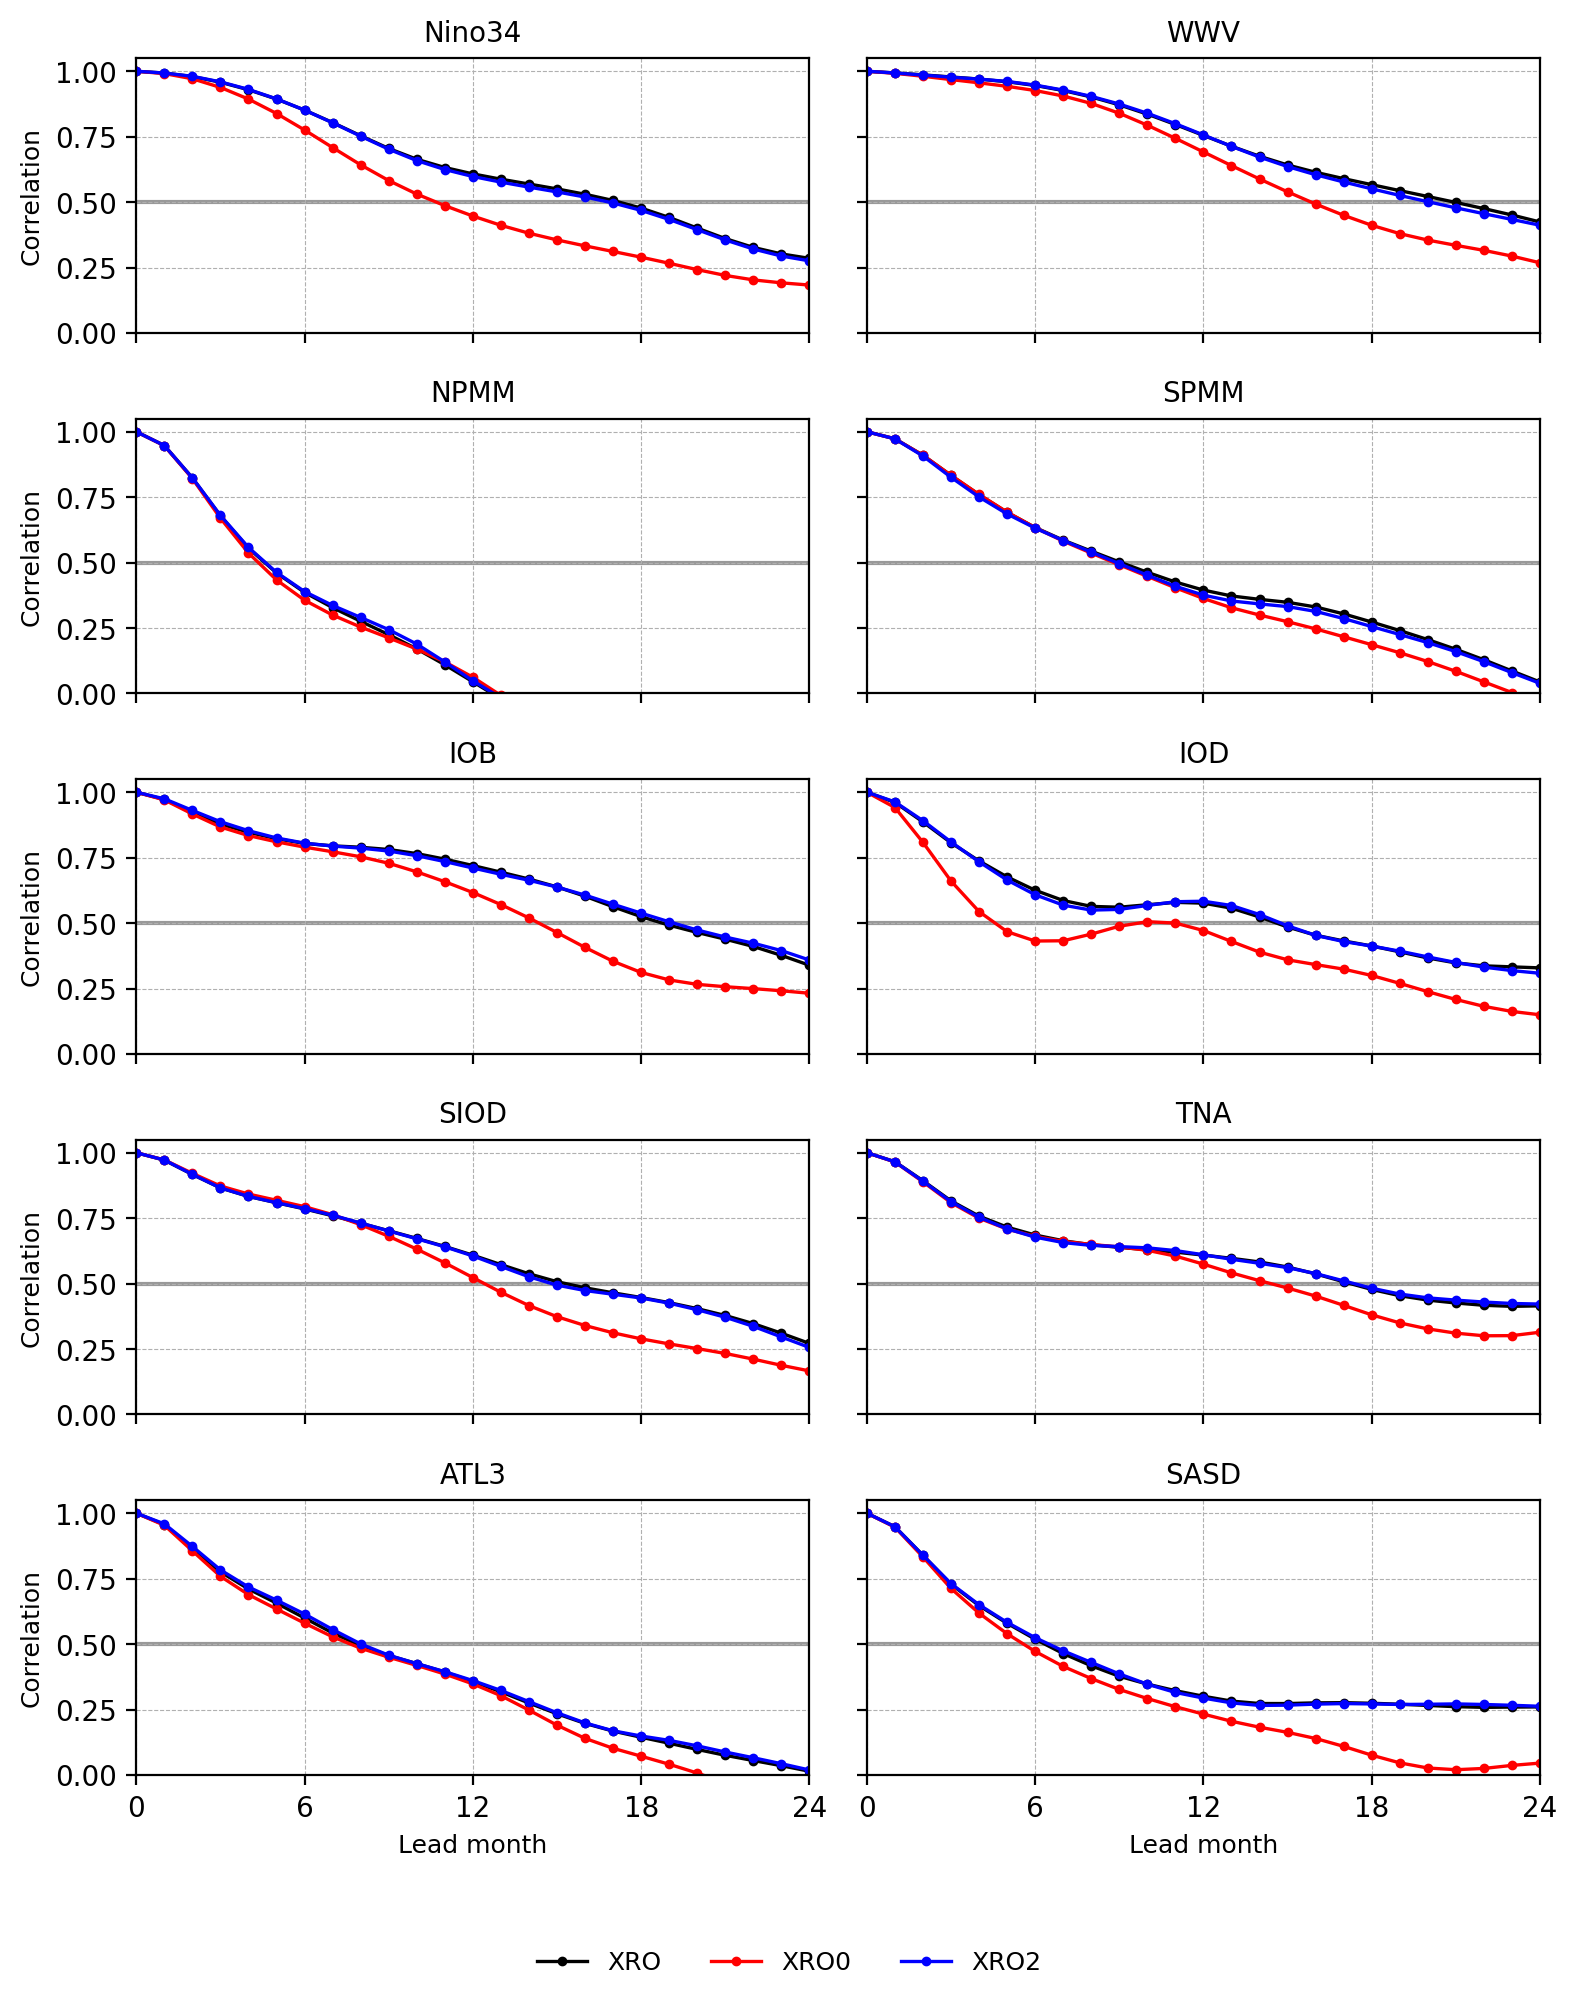

In [37]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_outofsample,
    "XRO0": acc_XRO_outofsample0,
    "XRO2": acc_XRO_outofsample2,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "XRO0": "red",
    "XRO2": "blue",
}
labels = {
    "XRO": "XRO",
    "XRO0": "XRO0",
    "XRO2": "XRO2",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


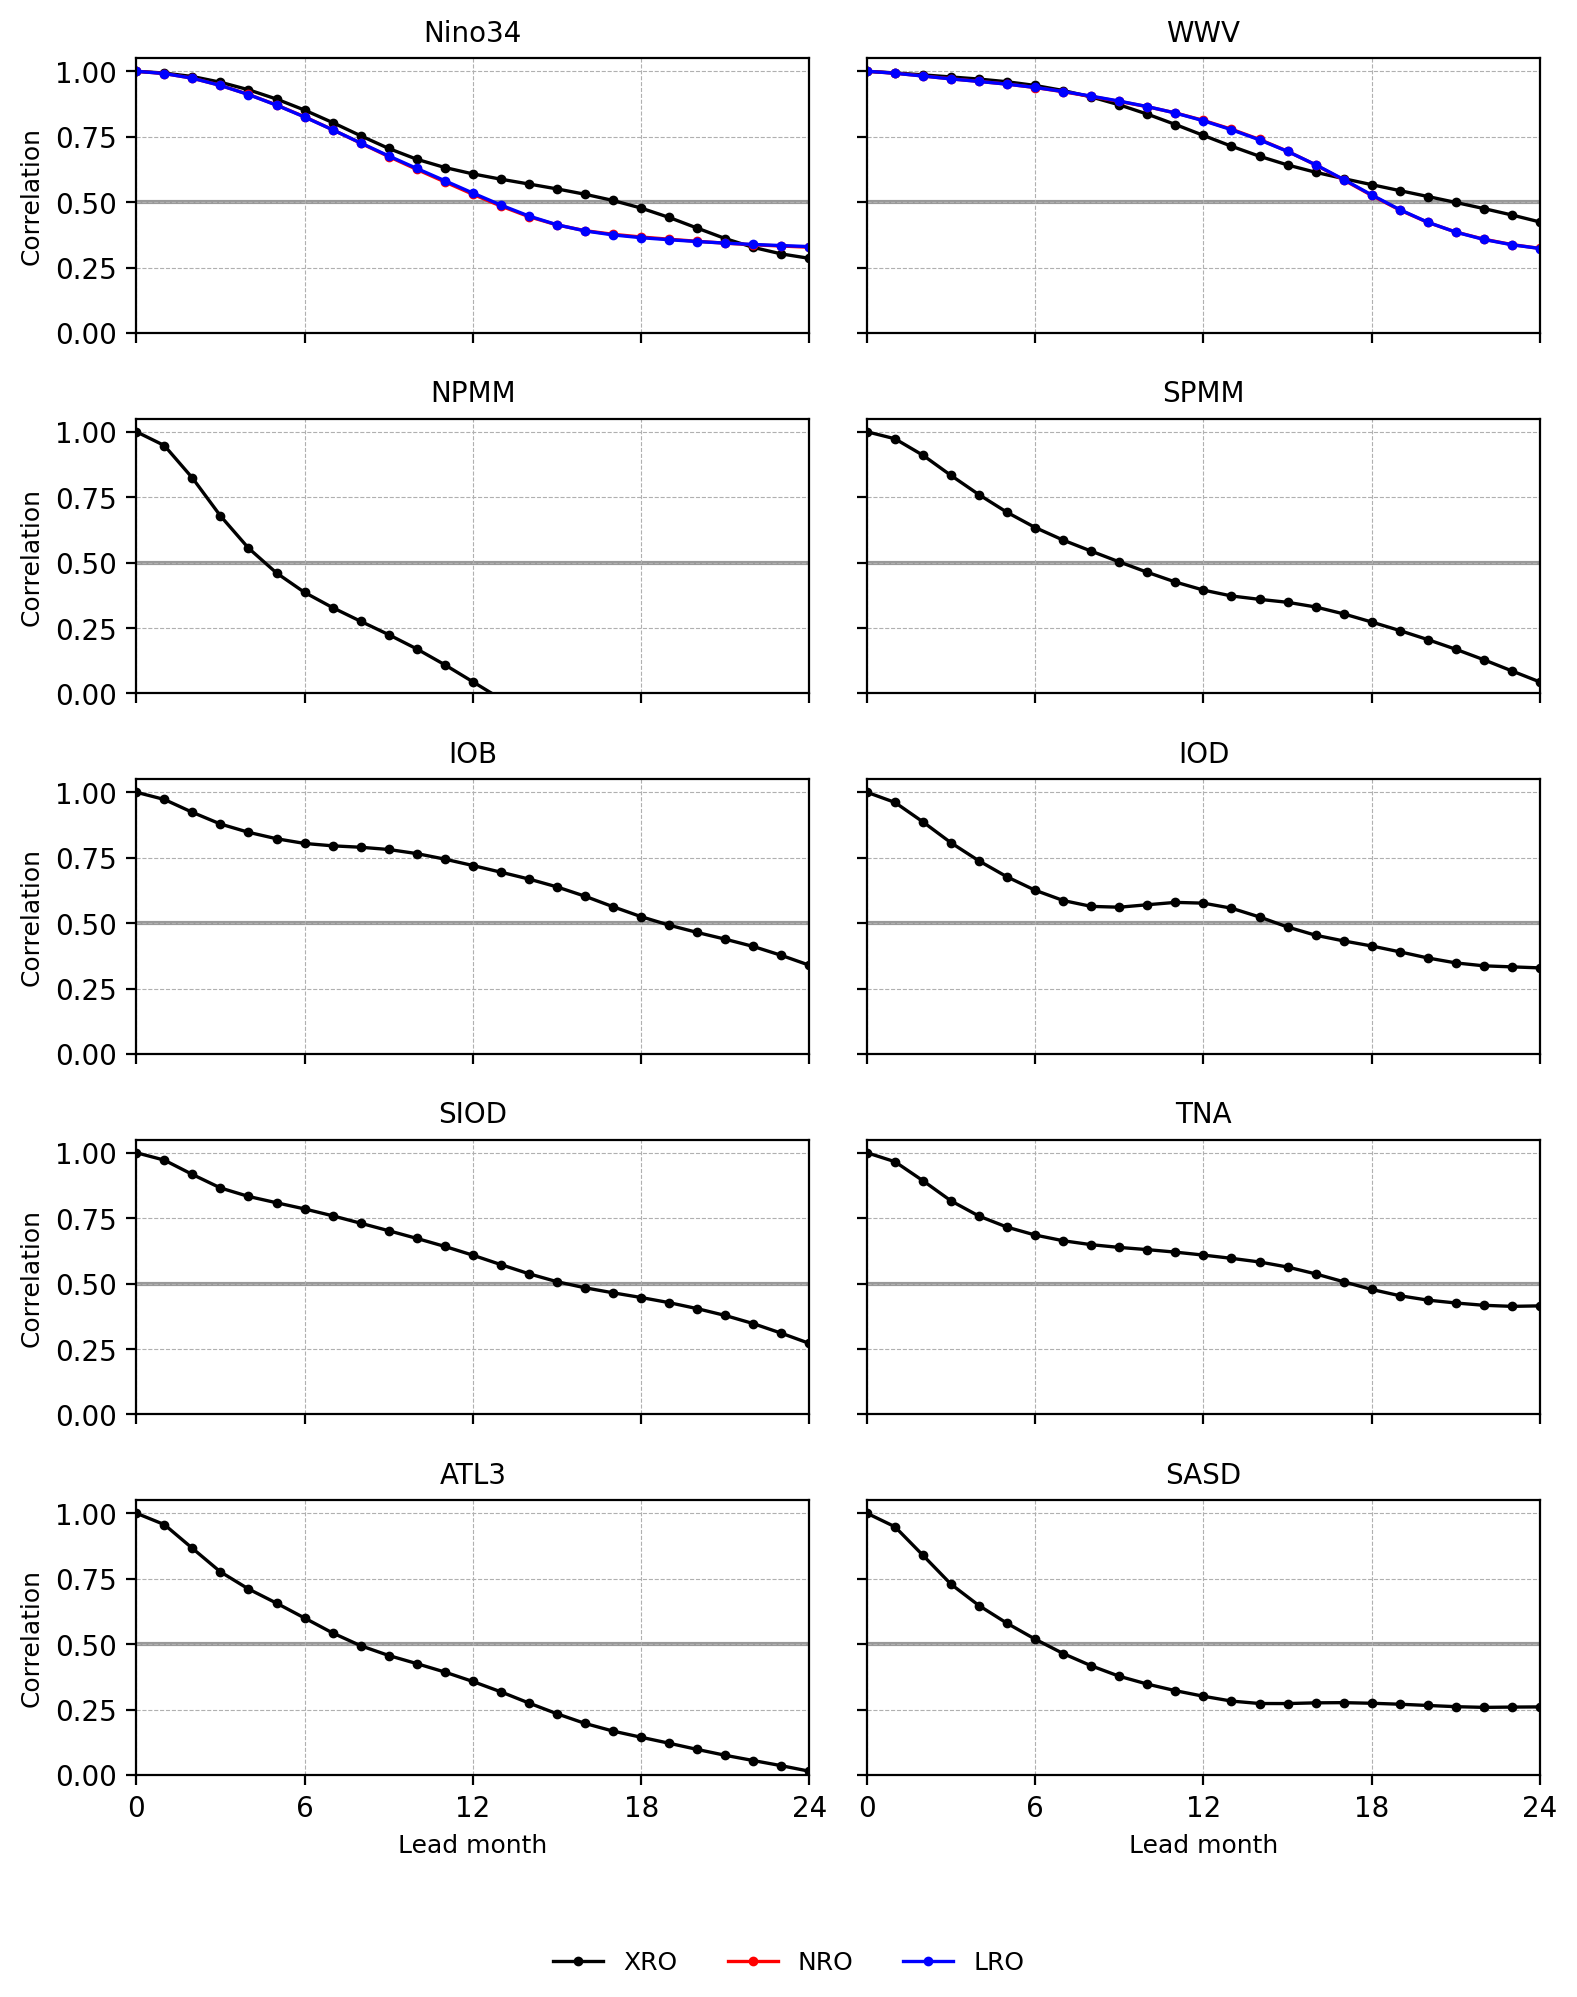

In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_outofsample,
    "NRO": acc_NRO_outofsample,
    "LRO": acc_LRO_outofsample,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "NRO": "red",
    "LRO": "blue",
}
labels = {
    "XRO": "XRO",
    "NRO": "NRO",
    "LRO": "LRO",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


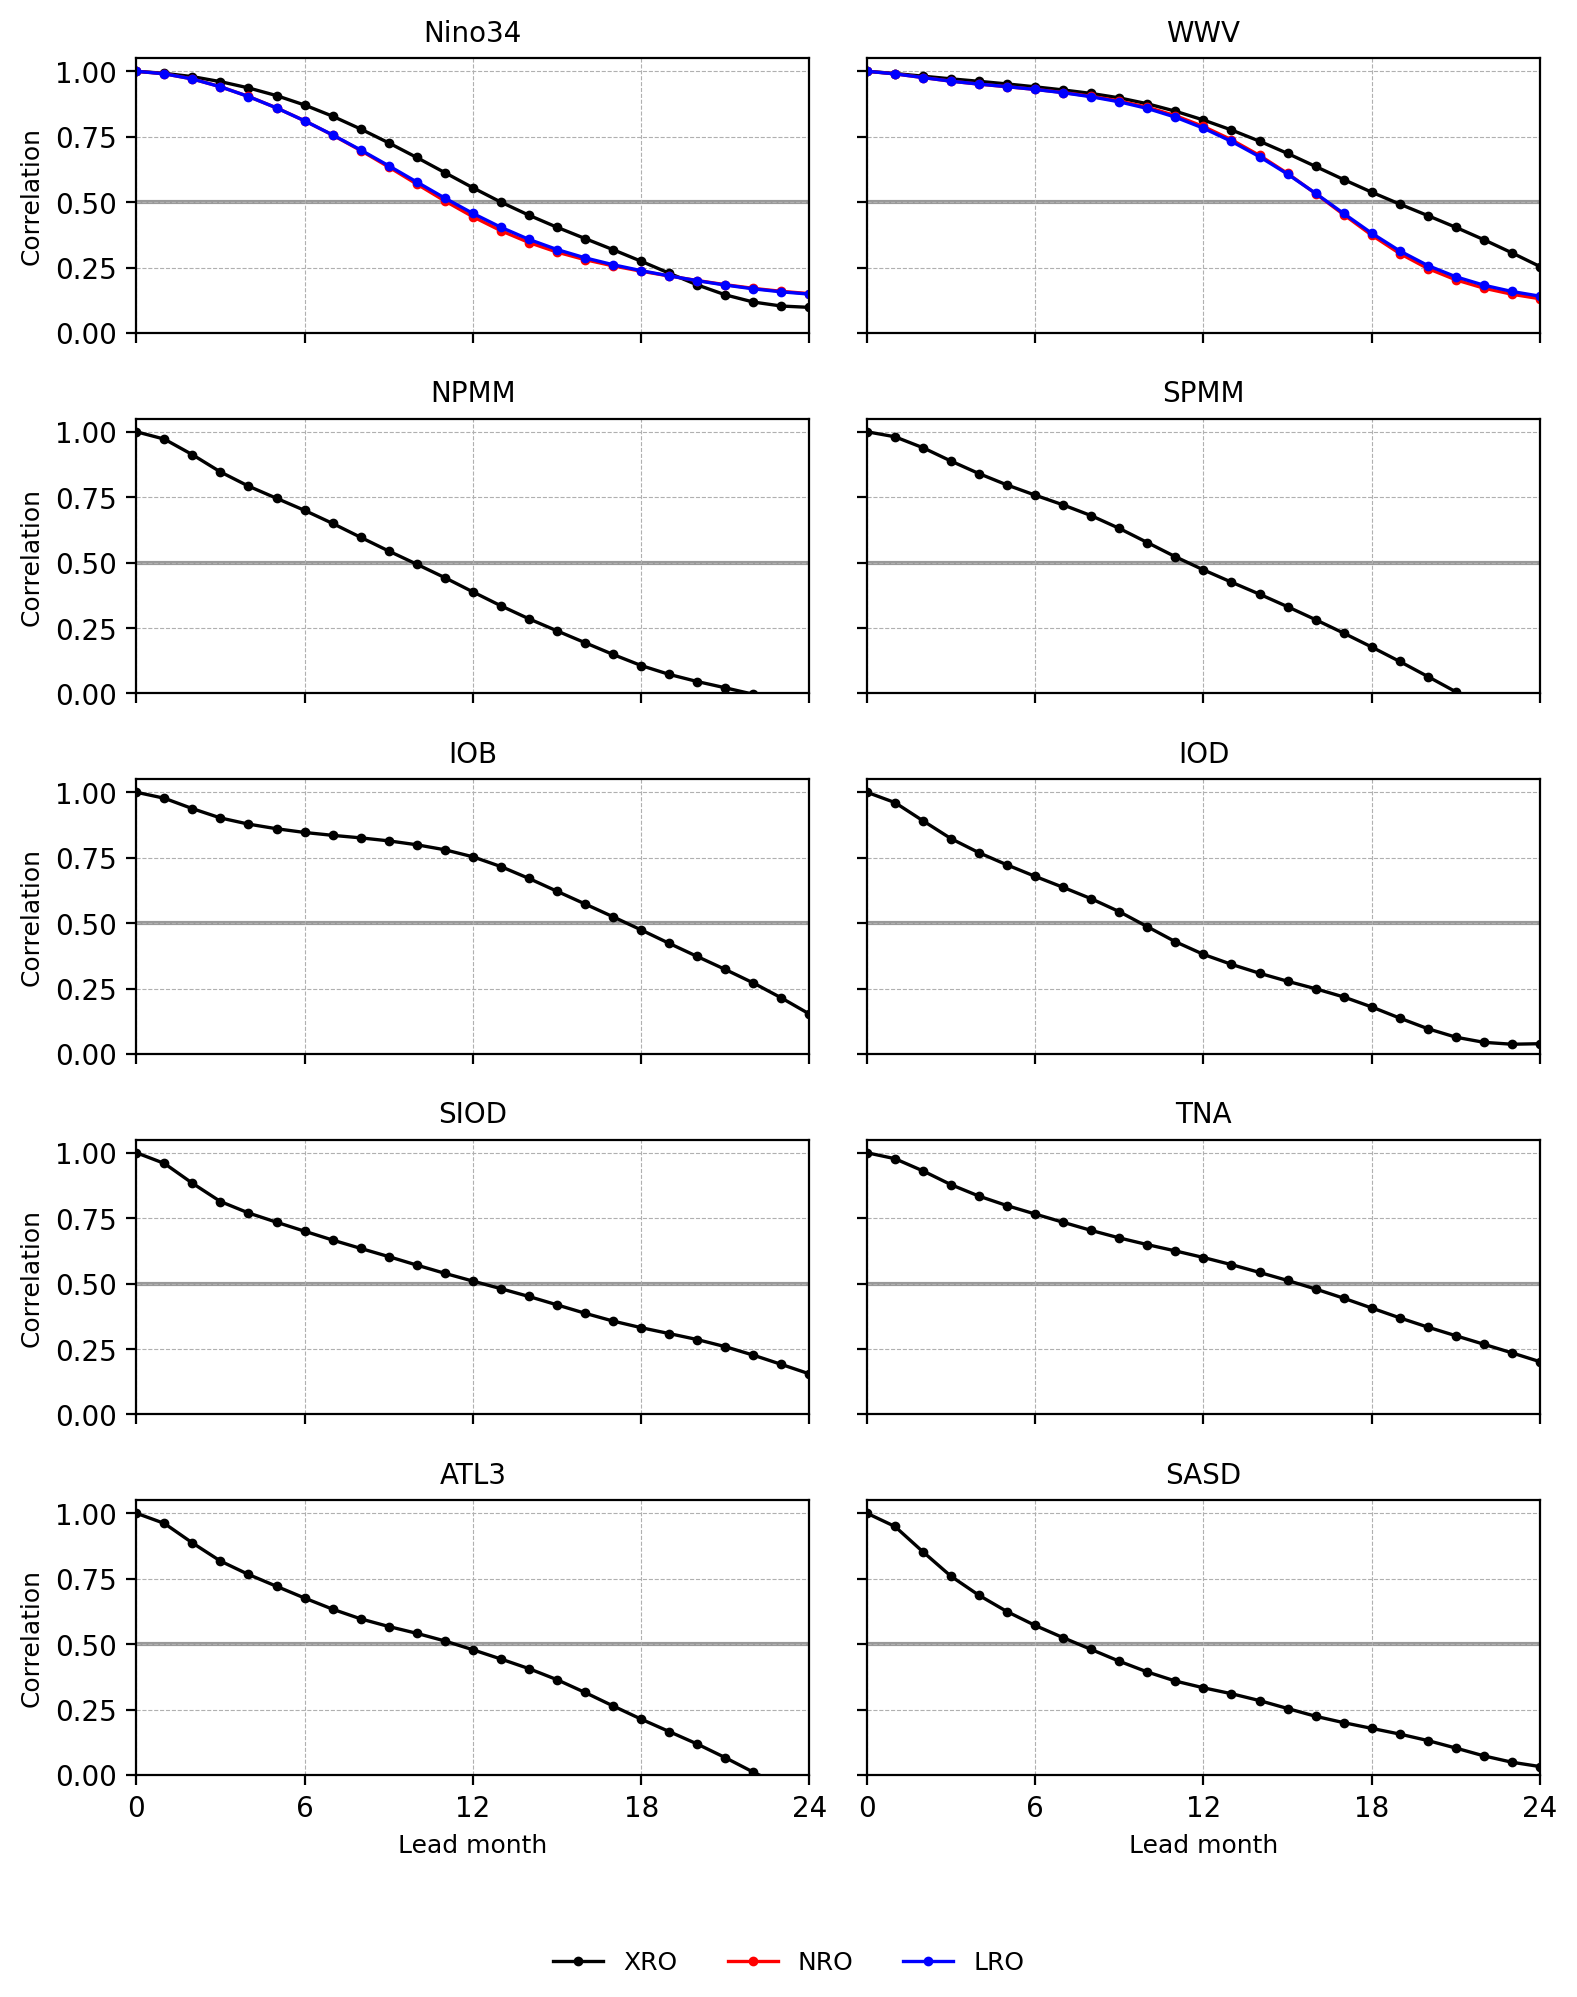

In [54]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_insample,
    "NRO": acc_NRO_insample,
    "LRO": acc_LRO_insample,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "NRO": "red",
    "LRO": "blue",
}
labels = {
    "XRO": "XRO",
    "NRO": "NRO",
    "LRO": "LRO",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


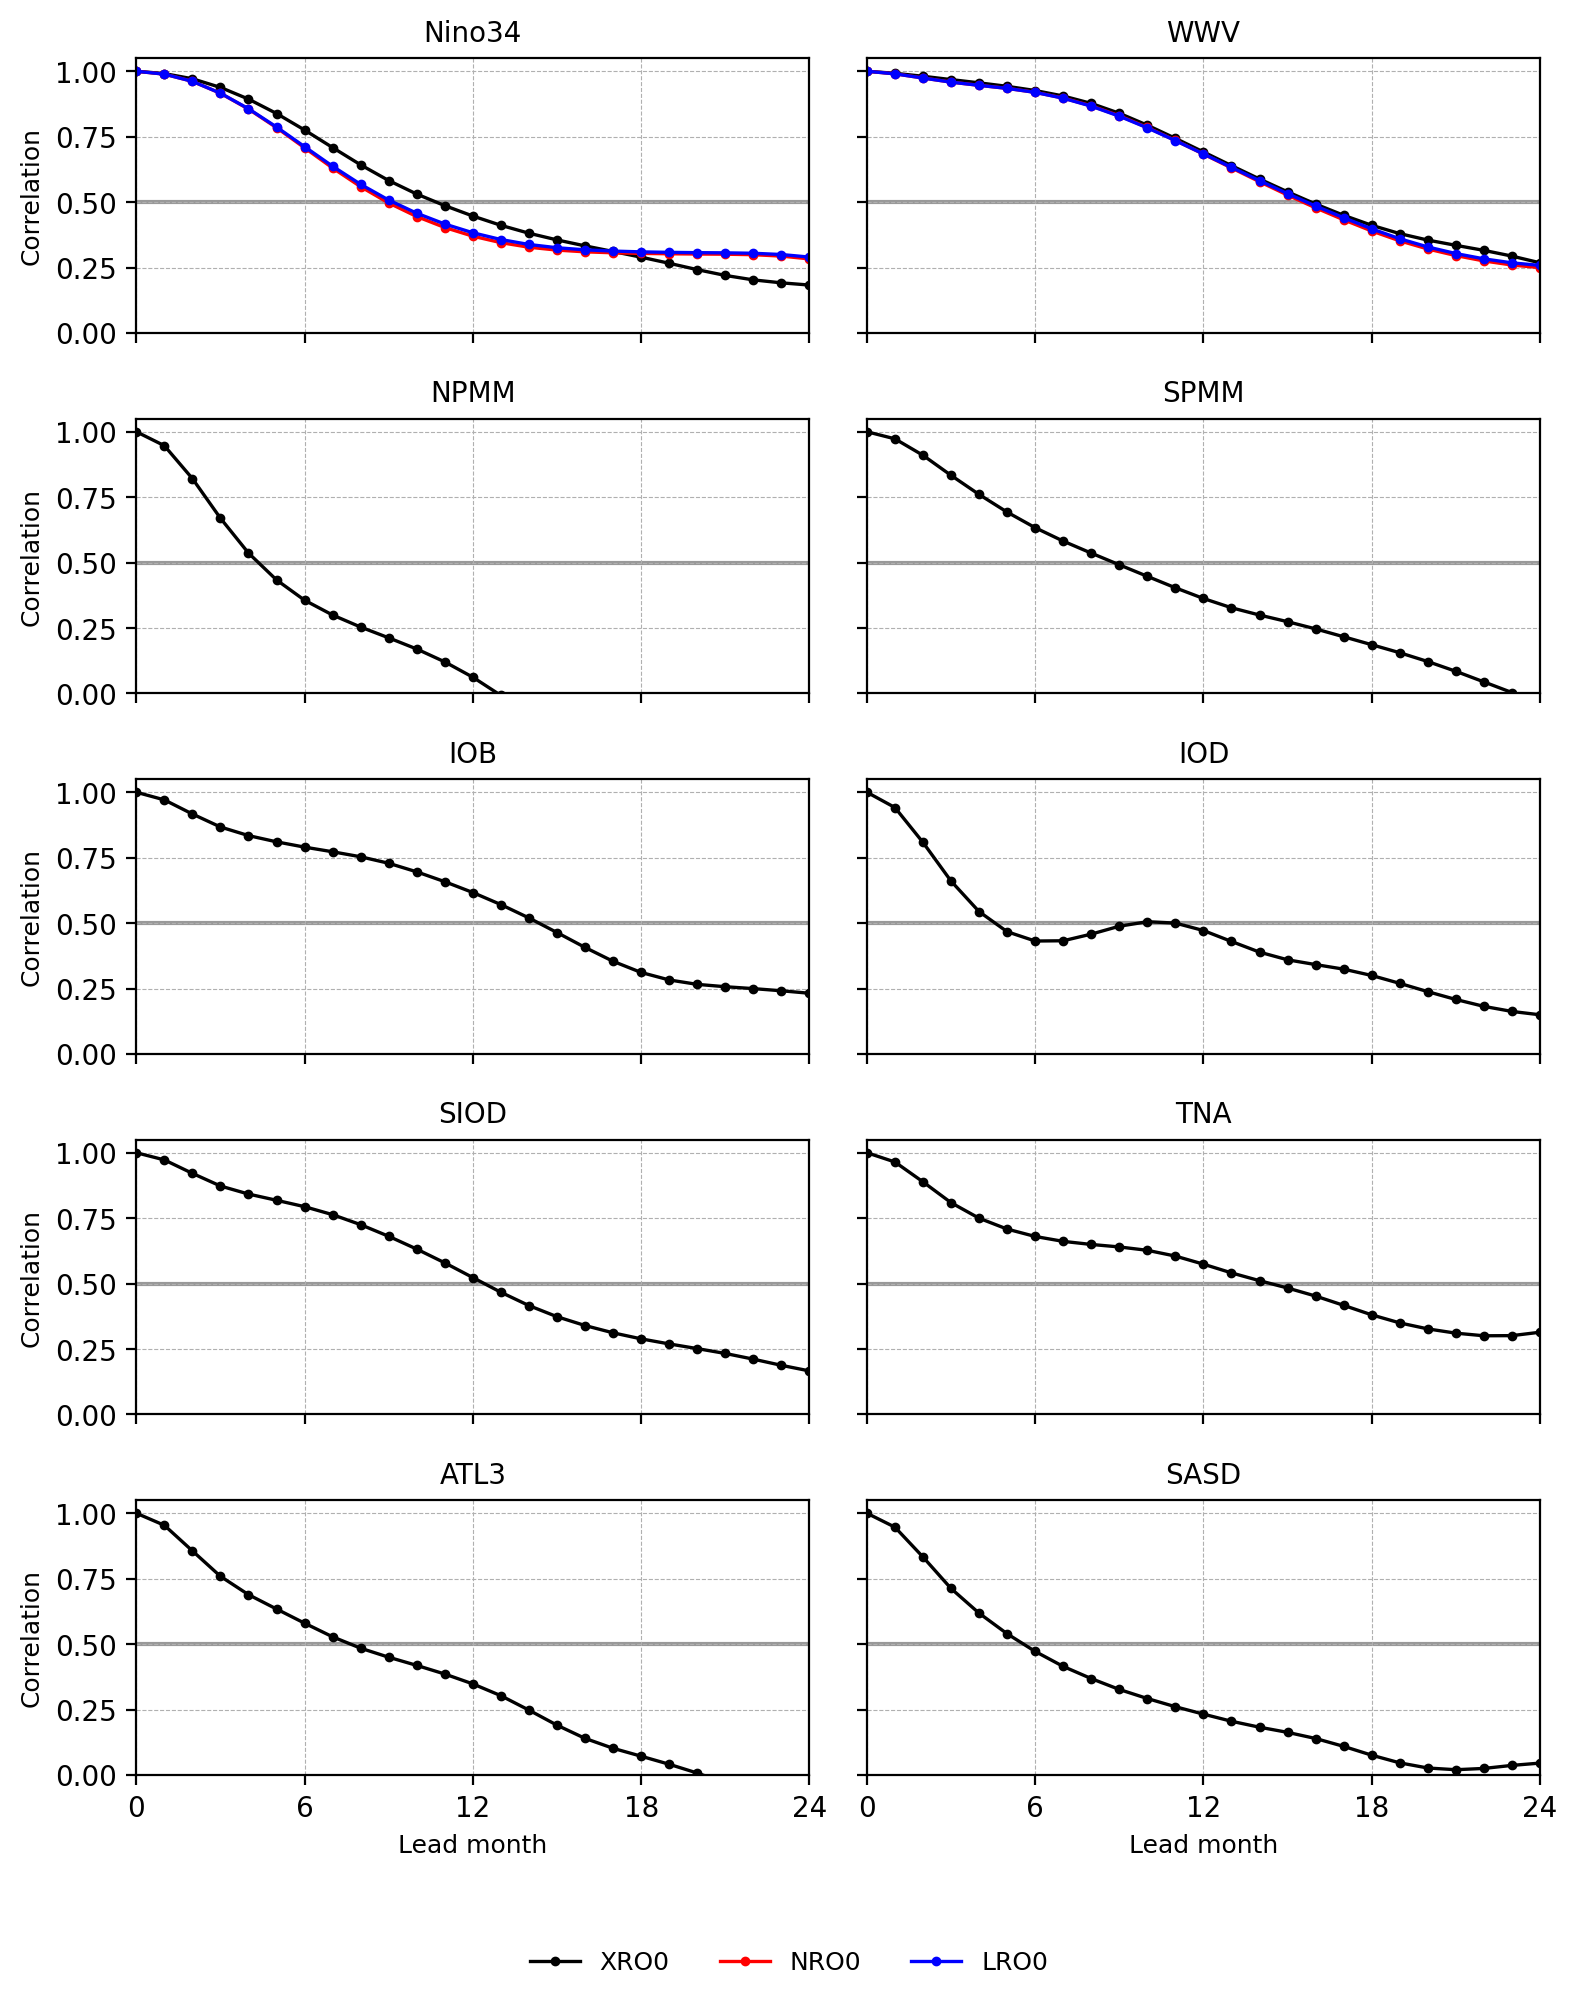

In [34]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO0": acc_XRO_outofsample0,
    "NRO0": acc_NRO_outofsample0,
    "LRO0": acc_LRO_outofsample0,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO0"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO0": "black",
    "NRO0": "red",
    "LRO0": "blue",
}
labels = {
    "XRO0": "XRO0",
    "NRO0": "NRO0",
    "LRO0": "LRO0",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


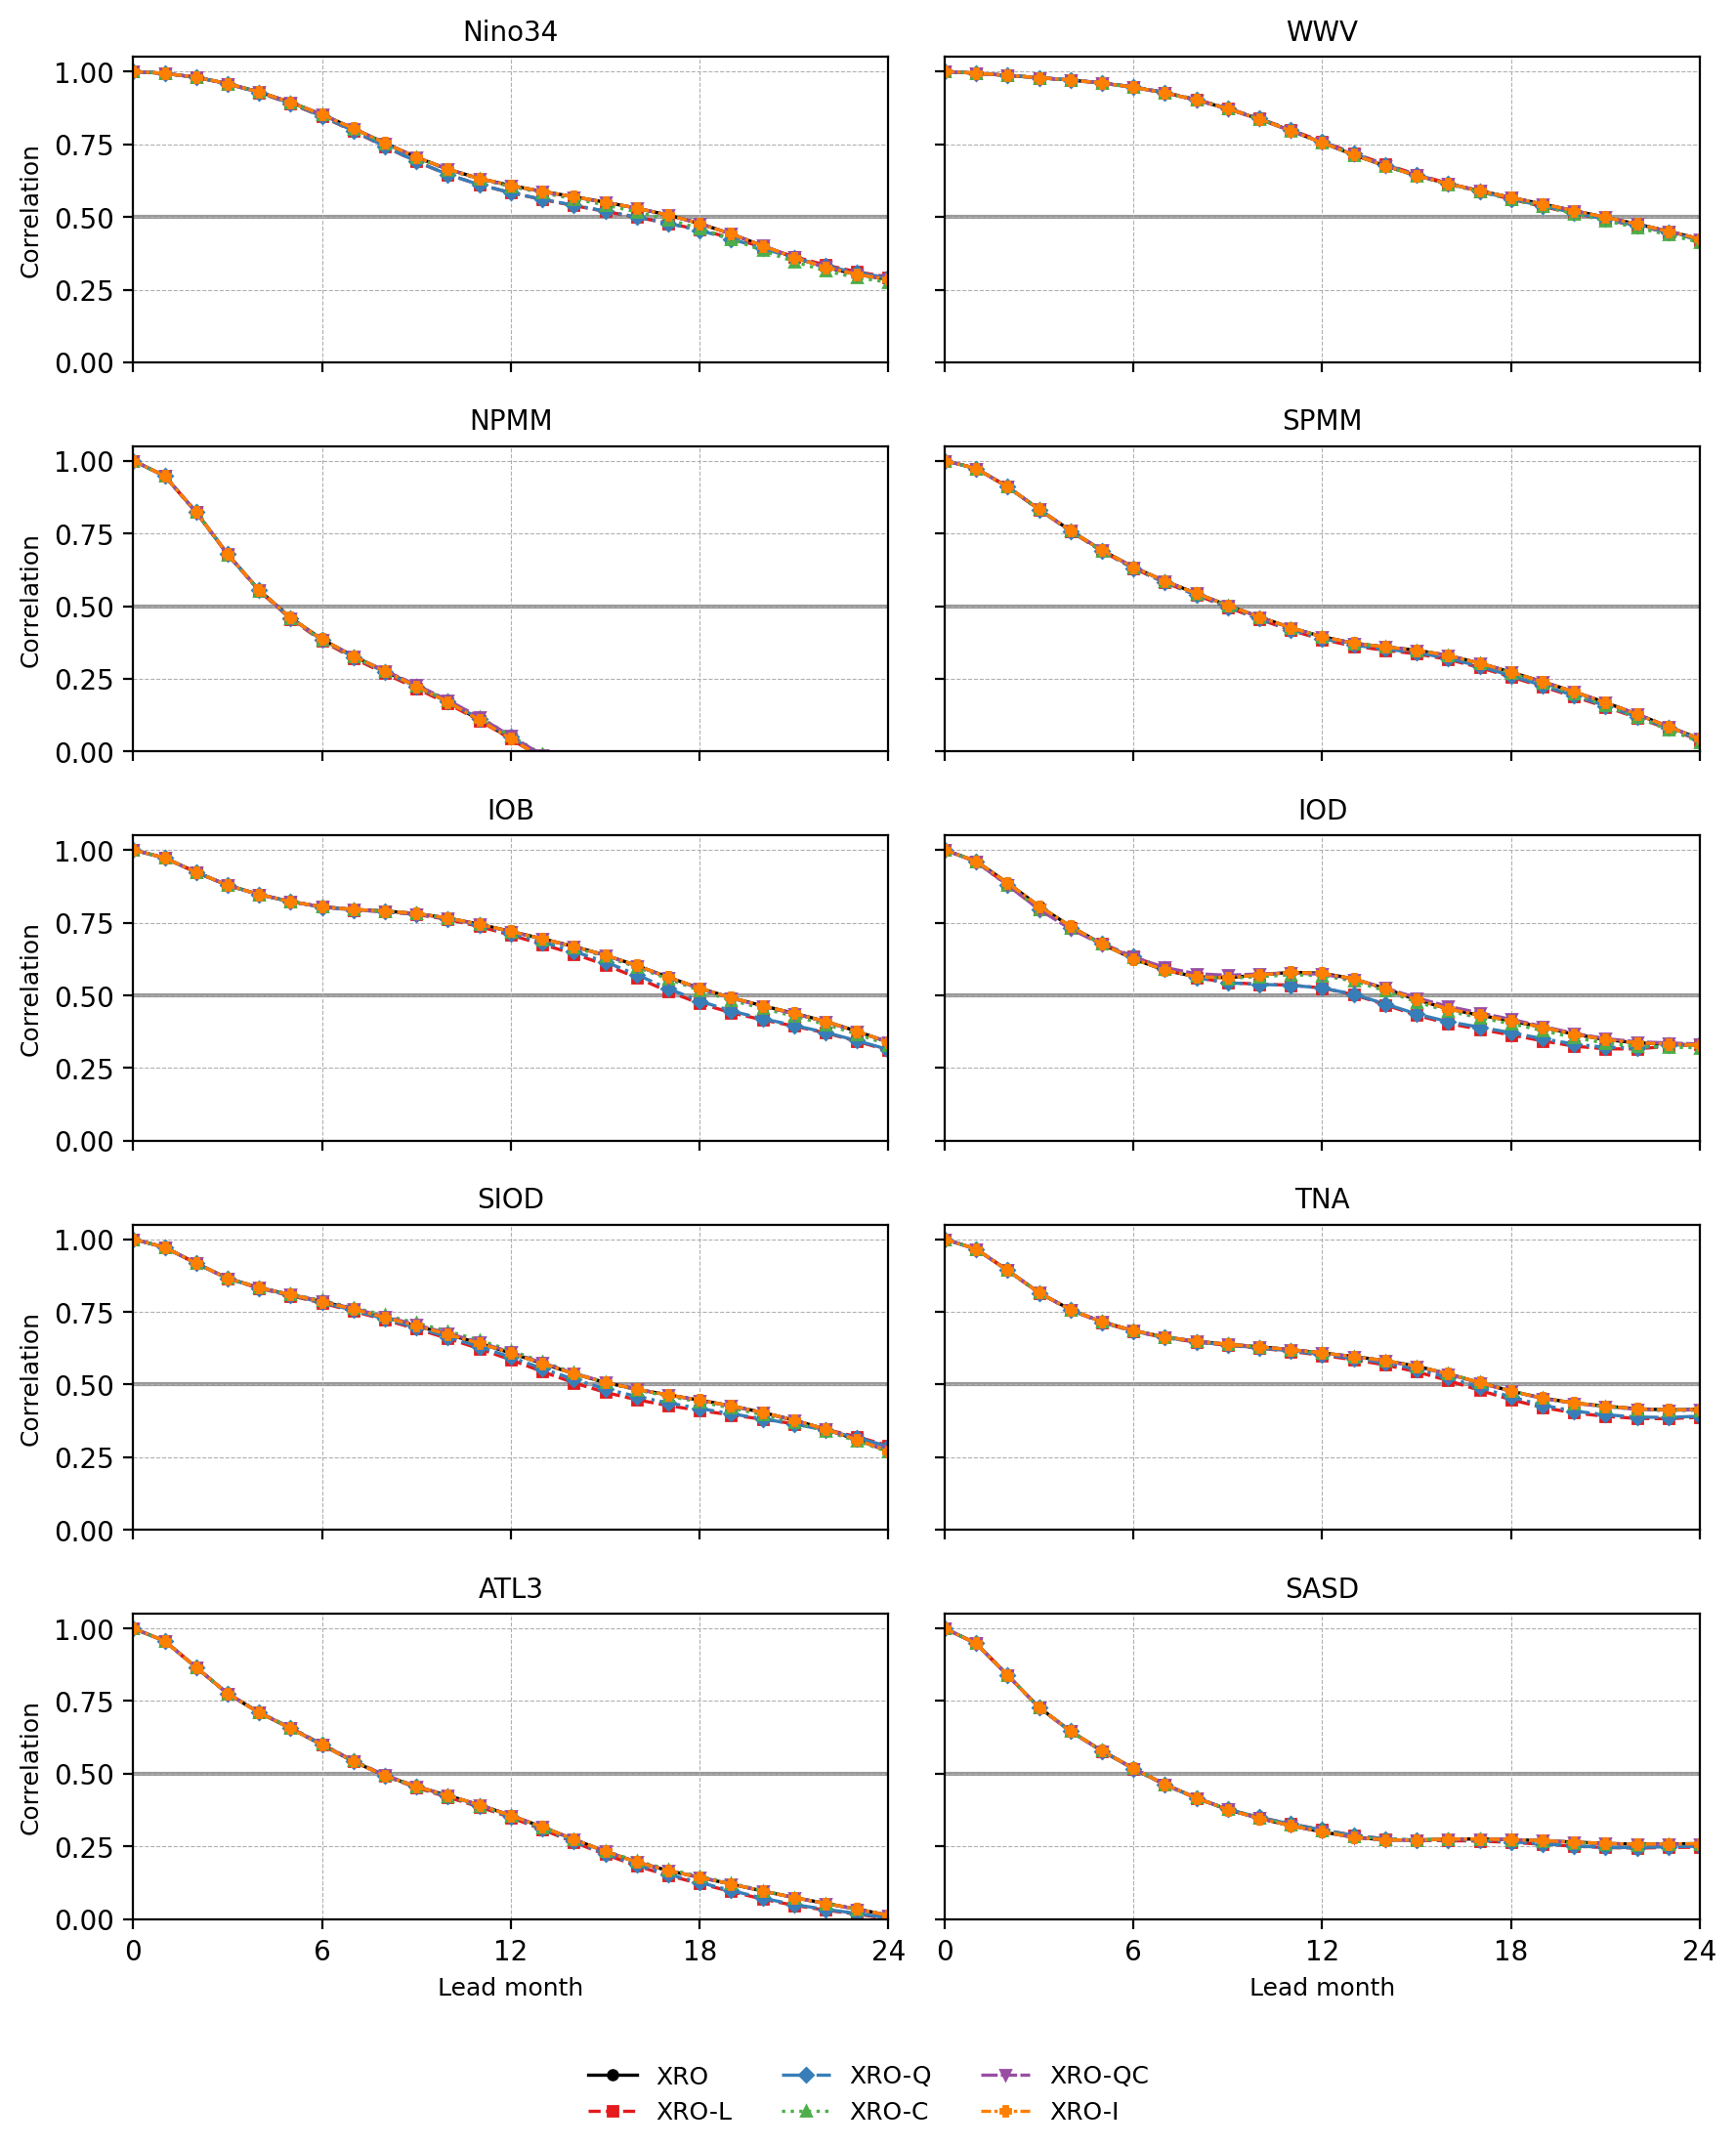

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

skill_sets = {
    "XRO": acc_XRO_outofsample,
    "XRO_L": acc_XRO_L_outofsample,
    "XRO_Q": acc_XRO_Q_outofsample,
    "XRO_C": acc_XRO_C_outofsample,
    "XRO_QC": acc_XRO_QC_outofsample,
    "XRO_I": acc_XRO_I_outofsample,
}

var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# --- colors, labels, markers, linestyles ---
colors = {
    "XRO": "black",
    "XRO_L": "#e41a1c",
    "XRO_Q": "#377eb8",
    "XRO_C": "#4daf4a",
    "XRO_QC": "#984ea3",
    "XRO_I": "#ff7f00",
}
labels = {
    "XRO": "XRO",
    "XRO_L": "XRO-L",
    "XRO_Q": "XRO-Q",
    "XRO_C": "XRO-C",
    "XRO_QC": "XRO-QC",
    "XRO_I": "XRO-I",
}
markers = ["o", "s", "D", "^", "v", "P"]
linestyles = ["-", "--", "-.", ":", (0, (5, 1)), (0, (3, 1, 1, 1))]  # 다양한 패턴

# --- figure layout ---
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(9, 11), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- skill curves ---
    for j, (key, ds) in enumerate(skill_sets.items()):
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker=markers[j % len(markers)],
            linestyle=linestyles[j % len(linestyles)],
            markersize=3.5,
            lw=1.2,
            label=labels[key],
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# --- remove empty subplots ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- legend ---
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [18]:
import os
import xarray as xr

# ------------------------------------------------------------
# Define datasets to save
# ------------------------------------------------------------
datasets_to_save = {
    "XRO": {"fit": fit_XRO_train, "acc": acc_XRO_outofsample},
    "NRO": {"fit": fit_NRO_train, "acc": acc_NRO_outofsample},
    "LRO": {"fit": fit_LRO_train, "acc": acc_LRO_outofsample},
}

# Output directory
OUT_DIR = "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Save loop
# ------------------------------------------------------------
for key, ds_dict in datasets_to_save.items():
    for dtype, ds in ds_dict.items():
        fname = f"{dtype}_{key}_train.nc"
        fpath = os.path.join(OUT_DIR, fname)

        # Ensure dataset is clean and loaded
        ds = ds.load()
        ds = ds.map(lambda x: x.astype(float) if x.dtype.kind in "iuf" else x)

        print(f"Saving: {fpath}")
        ds.to_netcdf(fpath)


Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/fit_XRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/acc_XRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/fit_NRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/acc_NRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/fit_LRO_train.nc
Saving: /mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/fit_outputs/acc_LRO_train.nc


In [19]:
def temporal_std_normalize(ds):
    """Normalize each variable by its temporal std (computed along 'time')."""
    normed_vars = {}
    for var in ds.data_vars:
        if "time" in ds[var].dims:
            std = ds[var].std(dim="time", skipna=True)
            normed_vars[var] = ds[var] / std
        else:
            # if variable has no time dimension, keep as is
            normed_vars[var] = ds[var]
    return xr.Dataset(normed_vars, coords=ds.coords, attrs=ds.attrs)

# Apply normalization
merged_ds_norm = temporal_std_normalize(merged_ds)

In [20]:
model_XRO_ds_norm = merged_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
model_NRO_ds_norm = merged_ds[['Nino34', 'WWV']]


In [21]:
slice_train = slice('1850-01', '1999-12')
slice_verif = slice('2000-01', '2024-12')

fit_XRO_norm_train = XRO_ac1.fit_matrix(model_XRO_ds_norm.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_norm_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_norm_train, init_ds=model_XRO_ds_norm.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_norm_outofsample = calc_forecast_skill(XRO_norm_outofsample_fcst, model_XRO_ds_norm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

rmse_XRO_norm_outofsample = calc_forecast_skill(XRO_norm_outofsample_fcst, model_XRO_ds_norm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

fit_NRO_norm_train = XRO_ac1.fit_matrix(model_NRO_ds_norm.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_norm_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_norm_train, init_ds=model_NRO_ds_norm.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_norm_outofsample = calc_forecast_skill(NRO_norm_outofsample_fcst, model_NRO_ds_norm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_NRO_norm_outofsample = calc_forecast_skill(NRO_norm_outofsample_fcst, model_NRO_ds_norm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

# fit_LRO_norm_NPP = XRO_ac1.fit_matrix(model_NRO_ds_norm, maskNT=[], maskNH=[])

fit_LRO_norm_train = XRO_ac1.fit_matrix(model_NRO_ds_norm.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_norm_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_LRO_norm_train, init_ds=model_NRO_ds_norm.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_norm_outofsample = calc_forecast_skill(LRO_norm_outofsample_fcst, model_NRO_ds_norm.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))
rmse_LRO_norm_outofsample = calc_forecast_skill(LRO_norm_outofsample_fcst, model_NRO_ds_norm.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2000-01', '2024-12'))

Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 1800), total X shape: (12, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 1800), total X shape: (11, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 1800), total X shape: (10, 1800)
Y shape: (1, 1800)
rank_y: 1
Y=0: active=[0 1 2 

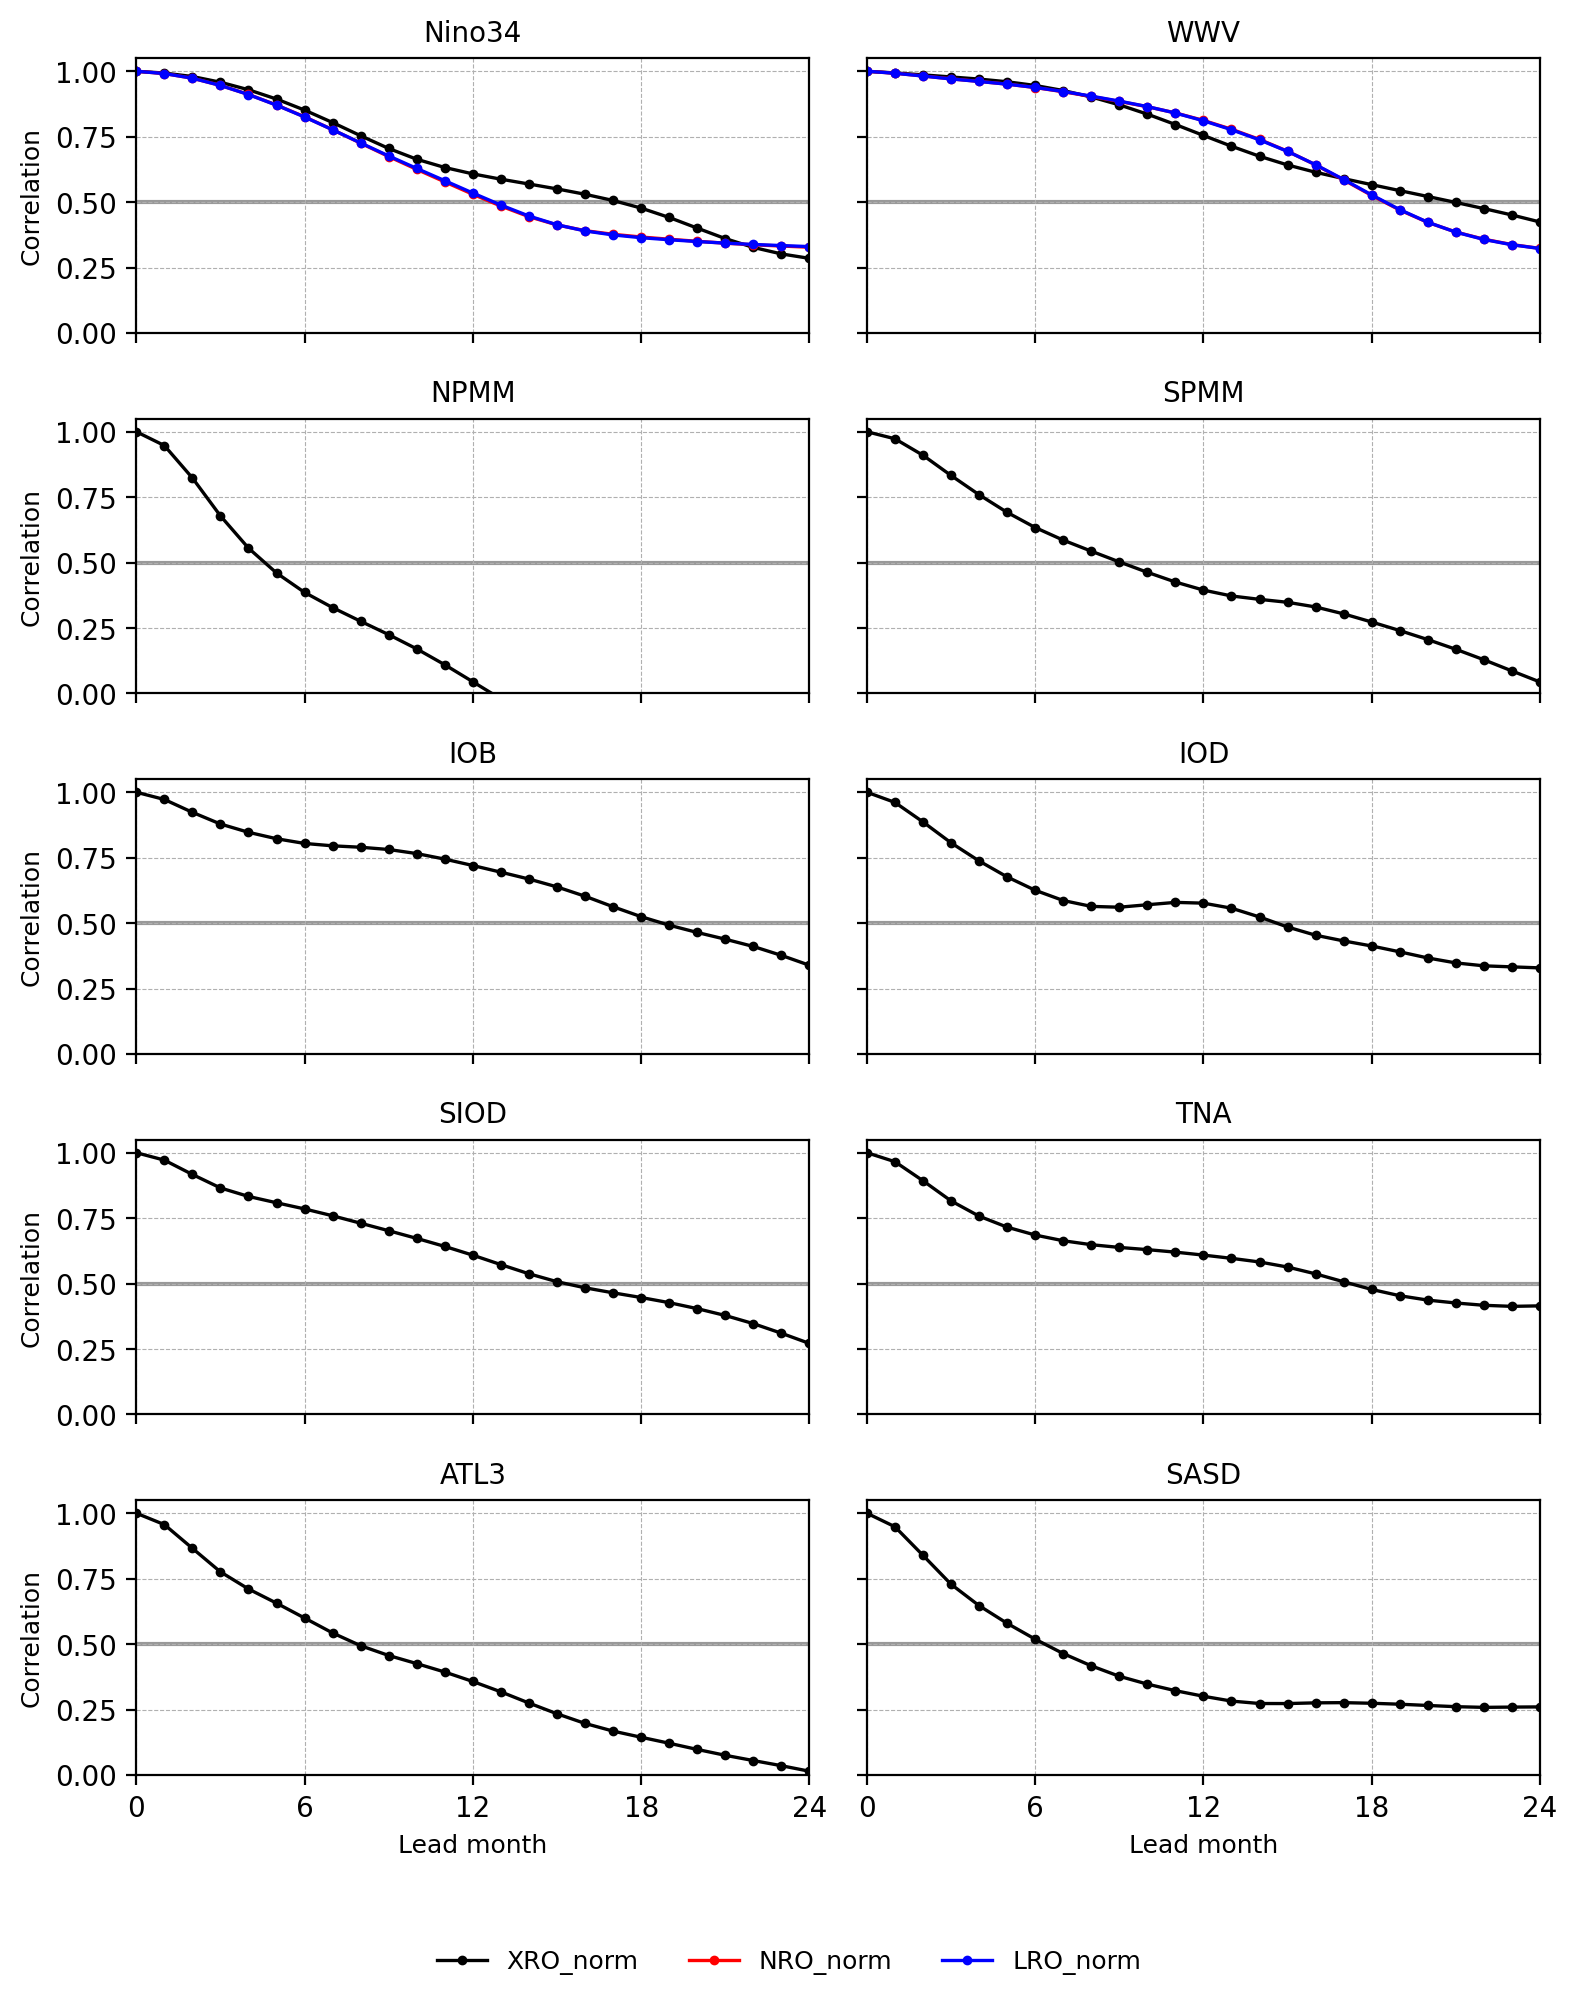

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Inputs (assumed to be loaded)
# ------------------------------------------------------------
skill_sets = {
    "XRO": acc_XRO_norm_outofsample,
    "NRO": acc_NRO_norm_outofsample,
    "LRO": acc_LRO_norm_outofsample,
}

# Variable list (order)
var_list = ["Nino34", "WWV", "NPMM", "SPMM", "IOB", "IOD", "SIOD", "TNA", "ATL3", "SASD"]
leads = skill_sets["XRO"].lead.values

# ------------------------------------------------------------
# Colors and labels
# ------------------------------------------------------------
colors = {
    "XRO": "black",
    "NRO": "red",
    "LRO": "blue",
}
labels = {
    "XRO": "XRO_norm",
    "NRO": "NRO_norm",
    "LRO": "LRO_norm",
}

# ------------------------------------------------------------
# Plot setup
# ------------------------------------------------------------
nvar = len(var_list)
ncol = 2
nrow = int(np.ceil(nvar / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # --- Plot benchmark line ---
    ax.axhline(0.5, color='gray', lw=1.5, alpha=0.8, zorder=0)
    
    # --- Plot skill curves ---
    for key, ds in skill_sets.items():
        if var not in ds:
            continue
        y = ds[var]
        ax.plot(
            leads, y,
            color=colors[key],
            marker="o",
            markersize=2.5,
            lw=1.2,
            label=labels[key]
        )
    
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, leads[-1])
    
    # --- Grid setup ---
    ax.set_xticks(np.arange(0, leads[-1] + 1, 6))
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.grid(True, ls="--", lw=0.4)
    
    if i >= (nrow - 1) * ncol:
        ax.set_xlabel("Lead month", fontsize=9)
    if i % ncol == 0:
        ax.set_ylabel("Correlation", fontsize=9)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------------------------------------
# Legend and layout
# ------------------------------------------------------------
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc="lower center", ncol=3, frameon=False, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
